In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from time import sleep

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set()

#### Cargamos el dataset  que tiene el siguiente formato
#### idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
#### 1975,21/03/2020,Re,NO,SI,09,22,25,31,40,15
#### 1975,21/03/2020,Tr,NO,SI,04,09,20,35,43,05

In [2]:
path_dataset = 'expdata2.csv'
df = pd.read_csv(path_dataset, parse_dates=['fecha'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 11 columns):
idSorteo    694 non-null int64
fecha       694 non-null datetime64[ns]
tipo        694 non-null object
ganador     694 non-null object
nuevo       694 non-null object
n1          694 non-null int64
n2          694 non-null int64
n3          694 non-null int64
n4          694 non-null int64
n5          694 non-null int64
sb          694 non-null int64
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 59.8+ KB


In [4]:
conteo_agrupados = df.groupby(['n1', 'n2','n3', 'n4','n5', 'sb']).size()
conteo_agrupados[conteo_agrupados > 1].sort_values(ascending=False).head(10)

Series([], dtype: int64)

### Definimos el contenido del diccionario que se encarga de interpretar los intervalos de los numeros

In [5]:
deltas = {
     0 : "=",  1 : "A",  2 : "B",  3 : "C",  4 : "D",  5 : "E",  6 : "F",  7 : "G",  8 : "H",  9 : "I", 10 : "J", 11 : "K", 12 : "L", 13 : "M", 14 : "N", 15 : "Ñ", 16 : "O", 17 : "P", 18 : "Q", 
    19 : "R", 20 : "S", 21 : "T", 22 : "U", 23 : "V", 24 : "W", 25 : "X", 26 : "Y", 27 : "Z", 28 : "@", 29 : "a", 30 : "b", 31 : "c", 32 : "d", 33 : "e", 34 : "f", 35 : "g", 36 : "h", 37 : "i", 
    38 : "j", 39 : "k", 40 : "l", 41 : "m", 42 : "n", 43 : "ñ", 44 : "o", 45 : "p", 46 : "q", 47 : "r", 48 : "s", 49 : "t", 50 : "u", 51 : "v", 52 : "w", 53 : "x", 54 : "y", 55 : "z" 
}

#### Creamos nuevo diccionario de pesos por los diferentes analisis

In [6]:
pesos = {
    0 : "0.0", 1 : "0.1", 2 : "0.2", 3: "0.3", 4 : "0.4", 5 : "0.5", 6 : "0.6", 7 : "0.7", 8 : "0.8", 9 : "0.9"     
}

#### Aquí se asignó el valor correspondiente en el diccionario a la diferencia entre los numeros de cada sorteo

In [7]:
def delta_translator(numero1, numero2, suma):
    if (suma > 0):
        return deltas[(suma - numero1) + numero2]
    else:
        return deltas[numero2 - numero1]

In [8]:
delta_translator(4,9,0)

'E'

#### Se encarga de construir una lista con las diferencias numericas para la diferencia entre el ultimo y el primer numero se usa la resta contra el mayor numero permitido al 1 de mayo de 2020 =>> 43

In [9]:
def word_maker(ent1, ent2, ent3, ent4, ent5):
    valDefec = 0
    maxValBal = 43
    listik = []
    listik.append(delta_translator(ent1, ent2, valDefec))
    listik.append(delta_translator(ent2, ent3, valDefec))
    listik.append(delta_translator(ent3, ent4, valDefec))
    listik.append(delta_translator(ent4, ent5, valDefec))
    listik.append(delta_translator(ent5, ent1, maxValBal))
    palabra = "".join(listik)
    return palabra

In [10]:
#print(word_maker(1, 8,17,41,43))

In [11]:
#df.describe()

#### Este es el dataframe sin filtrar

In [12]:
df.head(10)

,idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
0,2017,2020-09-19,Re,NO,SI,10,15,21,33,39,7
1,2017,2020-09-19,Tr,NO,SI,6,14,21,28,35,2
2,2016,2020-09-16,Re,NO,SI,7,15,18,29,32,14
3,2016,2020-09-16,Tr,NO,SI,2,19,22,25,37,15
4,2015,2020-12-09,Re,NO,SI,8,15,21,27,35,10
5,2015,2020-12-09,Tr,NO,SI,10,11,37,40,41,9
6,2014,2020-09-09,Re,NO,SI,1,9,18,23,38,6
7,2014,2020-09-09,Tr,NO,SI,7,11,16,30,35,3
8,2013,2020-05-09,Re,NO,SI,4,8,24,26,32,15
9,2013,2020-05-09,Tr,NO,SI,2,10,27,30,31,10


#### Aqui se crean los dataframes filtrados

In [13]:
propiedades = ["Tr"]
df_tr = df[df.tipo.isin(propiedades)]
propiedades = ["Re"]
df_re = df[df.tipo.isin(propiedades)]
#print(df_tr)

#### Aqui se partirian los dataframe en segmentos de entrenamiento y de testeo, a mayor frecuencia mayor peso se puede validar en conjunto para apuntarle a un sorteo con mayor cantidad de veces de ocurrencia

#### En este punto se filtran los sorteos para que solo sean sorteos de los nuevos puesto que la superbalota esta entre 1 y 16

In [14]:
sbs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]
df_sb_tr = df_tr[df_tr.sb.isin(sbs)]
df_sb_re = df_re[df_re.sb.isin(sbs)]
#print(df_sb_tr)

#### En este punto hago analisis frecuentista de la superbalota

In [15]:
dict_sb_tr = dict(df_tr.sb.value_counts())
print(dict_sb_tr)

{11: 36, 7: 31, 2: 28, 3: 25, 13: 24, 16: 23, 14: 19, 10: 19, 9: 19, 8: 19, 6: 19, 5: 19, 4: 18, 1: 18, 12: 17, 15: 13}


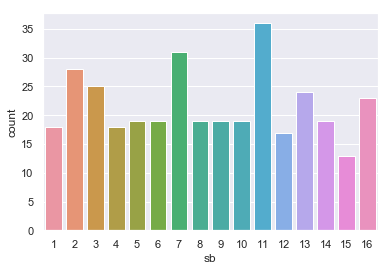

In [16]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_tr)

In [17]:
dict_sb_re = dict(df_re.sb.value_counts())
print(dict_sb_re)

{12: 31, 3: 27, 15: 25, 1: 25, 13: 24, 10: 24, 9: 24, 4: 23, 14: 22, 7: 22, 11: 20, 6: 18, 8: 17, 5: 16, 16: 15, 2: 14}


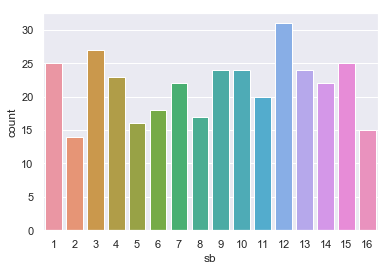

In [18]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_re)

In [19]:
dict_sb = dict(df.sb.value_counts())
print(dict_sb)

{11: 56, 7: 53, 3: 52, 13: 48, 12: 48, 10: 43, 9: 43, 1: 43, 2: 42, 14: 41, 4: 41, 16: 38, 15: 38, 6: 37, 8: 36, 5: 35}


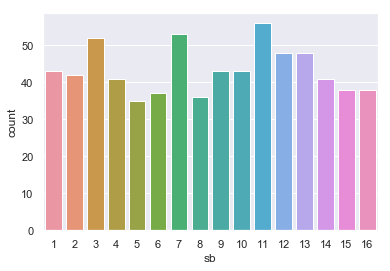

In [20]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df)

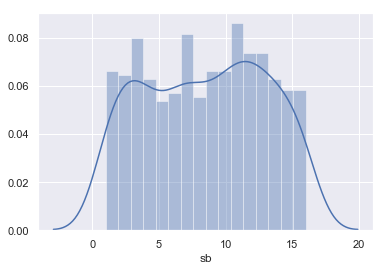

In [21]:
sns.set(style="darkgrid")
x= df.sb
ax = sns.distplot(x, bins=16)

In [22]:
#df.head()
categorical_cols = ['tipo','ganador']
unuseful_cols = ['fecha', 'nuevo']
le = LabelEncoder()

for item in categorical_cols[:]:
    if item == 'tipo' or item == 'ganador':
        nombre_col = str(item) + str('Tr')
        df_tr[nombre_col]= le.fit_transform(df_tr[item])
        nombre_col = str(item) + str('Re')
        df_re[nombre_col]= le.fit_transform(df_re[item])
#print(df_tr)
#print(df_re)

C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
df_tr_fusion = []
df_re_fusion = []
print(df_tr)
df_tr_fusion = df_tr.drop(unuseful_cols, axis=1)
df_re_fusion = df_re.drop(unuseful_cols, axis=1)
print(df_tr_fusion)
df_tr_fu_filt = df_tr_fusion.iloc[:, [0,3,4,5,6,7,8]]
df_re_fu_filt = df_re_fusion.iloc[:, [0,3,4,5,6,7,8]]
Y_tr = df_tr_fusion.iloc[:, 10]
Y_re = df_re_fusion.iloc[:, 10]
filas = int(df_sb_tr.shape[0])
print(df_tr_fu_filt)
print(df_re_fu_filt)

     idSorteo      fecha tipo ganador nuevo  n1  n2  n3  n4  n5  sb  tipoTr  \
1        2017 2020-09-19   Tr      NO    SI   6  14  21  28  35   2       0   
3        2016 2020-09-16   Tr      NO    SI   2  19  22  25  37  15       0   
5        2015 2020-12-09   Tr      NO    SI  10  11  37  40  41   9       0   
7        2014 2020-09-09   Tr      NO    SI   7  11  16  30  35   3       0   
9        2013 2020-05-09   Tr      NO    SI   2  10  27  30  31  10       0   
..        ...        ...  ...     ...   ...  ..  ..  ..  ..  ..  ..     ...   
684      1675 2017-06-05   Tr      NO    SI   1  20  36  39  43  10       0   
686      1674 2017-03-05   Tr      NO    SI   5   6   7  12  37   6       0   
688      1673 2017-04-29   Tr      NO    SI   6  19  25  28  36   1       0   
690      1672 2017-04-26   Tr      NO    SI   1   2  25  31  33  14       0   
692      1671 2017-04-22   Tr      NO    SI  15  28  36  37  41  10       0   

     ganadorTr  
1            0  
3            0  


In [24]:
def addcolumn(df):
    delta=[]
    for index, row in df.iterrows():
        delta.append(word_maker(row.n1, row.n2, row.n3, row.n4, row.n5))
    df['delta'] = delta
    return df

In [25]:
#NO BORRAR adiciona columnas de los deltas

#df_tr_fu_filt = addcolumn(df_tr_fu_filt)

In [26]:
#print (df_tr_fu_filt)

In [27]:
sorteos = df_tr_fu_filt.shape
print (df_tr_fu_filt)
print(range(sorteos[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
1        2017   6  14  21  28  35   2
3        2016   2  19  22  25  37  15
5        2015  10  11  37  40  41   9
7        2014   7  11  16  30  35   3
9        2013   2  10  27  30  31  10
..        ...  ..  ..  ..  ..  ..  ..
684      1675   1  20  36  39  43  10
686      1674   5   6   7  12  37   6
688      1673   6  19  25  28  36   1
690      1672   1   2  25  31  33  14
692      1671  15  28  36  37  41  10

[347 rows x 7 columns]
range(0, 347)


In [28]:
df_tr_fu_filt_1 = df_tr_fu_filt[(df_tr_fu_filt['n1']==1) & (df_tr_fu_filt['n2']==2)]
df_tr_fu_filt_2 = df_tr_fu_filt_1[df_tr_fu_filt_1['n2']==3]
#df_tr_fu_filt_1 = df_tr_fu_filt.filter(='10', axis=0)
sorteos2 = df_tr_fu_filt_1.shape
print (df_tr_fu_filt_1)

print(range(sorteos2[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
234      1900   1   2   3  10  31   1
254      1890   1   2  22  29  42  16
544      1745   1   2   4   5  13  10
546      1744   1   2  33  34  41  10
612      1711   1   2  20  31  43   8
690      1672   1   2  25  31  33  14
range(0, 6)


In [29]:
df_tr_fu_filt = addcolumn(df_tr_fu_filt)
df_tr_fu_filt.to_csv(r'df_tr_fu_filt_delta.csv', header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='a')
print(df_tr_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb  delta
1        2017   6  14  21  28  35   2  HGGGN
3        2016   2  19  22  25  37  15  PCCLH
5        2015  10  11  37  40  41   9  AYCAL
7        2014   7  11  16  30  35   3  DENEÑ
9        2013   2  10  27  30  31  10  HPCAN
..        ...  ..  ..  ..  ..  ..  ..    ...
684      1675   1  20  36  39  43  10  ROCDA
686      1674   5   6   7  12  37   6  AAEXK
688      1673   6  19  25  28  36   1  MFCHM
690      1672   1   2  25  31  33  14  AVFBK
692      1671  15  28  36  37  41  10  MHADP

[347 rows x 8 columns]


C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [30]:
df_re_fu_filt = addcolumn(df_re_fu_filt)
df_re_fu_filt.to_csv(r'df_re_fu_filt_delta.csv', header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='a')
print(df_re_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb  delta
0        2017  10  15  21  33  39   7  EFLFN
2        2016   7  15  18  29  32  14  HCKCQ
4        2015   8  15  21  27  35  10  GFFHO
6        2014   1   9  18  23  38   6  HIEÑF
8        2013   4   8  24  26  32  15  DOBFÑ
..        ...  ..  ..  ..  ..  ..  ..    ...
685      1675   3   5   8  20  24  14  BCLDU
687      1674   5  12  15  20  42  14  GCEUF
689      1673   8  21  22  37  38   4  MAÑAM
691      1672   9  12  16  28  38   1  CDLJN
693      1671   3   9  10  21  40  10  FAKRF

[347 rows x 8 columns]


C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [31]:
#sorteo = df_tr_fu_filt[df_tr_fu_filt.idSorteo == '198']
#print(sorteo)
#df_tr_fu_filt.loc['n1'].tolist()
#idSorteo = '1975'
#values = df_tr_fu_filt.loc[idSorteo].tolist()
#print(values)


In [32]:
#df_tr_fu_filt.delta.value_counts()

In [33]:
df_re_fu_filt.delta.value_counts()

DOGEK    1
GARBN    1
GABHX    1
AODFO    1
LJBAQ    1
        ..
ARKAK    1
BAÑFR    1
EAGHU    1
LLCKE    1
CIGER    1
Name: delta, Length: 347, dtype: int64

In [34]:
#def transforma_unos(df_tr_fu_filt)
#    for i in range(0, df_tr_fu_filt.shape[1])
        


los numeros de las columnas n1-n5 seran fusionadas, seran transformados a una sola dimension, para poder determinar la frecuencia con la que acontecen, en primera instancia seran separados por tipo de sorteo, y en el nuevo dataset tendremos el numero del sorteo y el numero

In [35]:
#print(Y_tr)
#print(Y_re)
main_columns = ['n1','n2','n3', 'n4', 'n5', 'sb','tipo', 'ganador']

Este contenido se usa para segmentar el dataframe en los siguientes contextos single, duplas, ternas cuartetos y quintetos con y sin superbalota

In [36]:
def cortasingles(df, col0, col1):
    df_filt = df.iloc[0::1,[col0, col1]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [37]:
def cortasinglessb(df, col0, col1, sb):
    df_filt = df.iloc[0::1,[col0, col1, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [38]:
def cortaduplas(df, col0, col1, col2):
    df_filt = df.iloc[0::1,[col0, col1, col2]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [39]:
def cortaduplassb(df, col0, col1, col2, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [40]:
def cortatrios(df, col0, col1, col2, col3):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [41]:
def cortatriossb(df, col0, col1, col2, col3, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [42]:
def cortacuartetos(df, col0, col1, col2, col3, col4):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [43]:
def cortacuartetossb(df, col0, col1, col2, col3, col4, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [44]:
def cortaquintetos(df, col0, col1, col2, col3, col4, col5):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [45]:
def cortaquintetossb(df, col0, col1, col2, col3, col4, col5, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

El siguiente contenido se usa para fusionar los dataframes desde los diferentes enfoques, singles, duplas, trios, etc

In [46]:
def concatenador_singles(df, sb):
    colid = 0
    df_1d_fu_tr = cortasinglessb(df,colid,1, sb) if sb > 0 else cortasingles(df,colid,1)
    for i in range(1,6):
        if (i == 1) :
            i = i+1
            df_temp_fusion = cortasinglessb(df, colid, i, sb) if sb > 0 else cortasingles(df, colid, i)
            df_1d_fu_tr = pd.concat([df_1d_fu_tr, df_temp_fusion], ignore_index=True)
        else :
            df_temp_fusion = cortasinglessb(df, colid, i, sb) if sb > 0 else cortasingles(df, colid, i)
            df_1d_fu_tr = pd.concat([df_1d_fu_tr, df_temp_fusion], ignore_index=True)
    df_1d_fu_tr.columns = ['idSorteo', 'num1', 'sb'] if sb > 0 else ['idSorteo', 'num1']
    return df_1d_fu_tr

In [47]:
def concatenador_duplas(df,sb):
    colid = 0
    df_2d_fu_tr = cortaduplassb(df, colid, 1, 2, sb) if sb > 0 else cortaduplas(df, colid, 1, 2)
    for i in range(1,6):
        for ii in range(i+1, 6):
            if (i == 1 & ii == 2) :
                ii = ii+1
                df_temp_fusion = cortaduplassb(df, colid, i, ii, sb) if sb > 0 else cortaduplas(df, colid, i, ii)
                df_2d_fu_tr = pd.concat([df_2d_fu_tr, df_temp_fusion], ignore_index=True)
            else :
                df_temp_fusion = cortaduplassb(df, colid, i, ii, sb) if sb > 0 else cortaduplas(df, colid, i, ii)
                df_2d_fu_tr = pd.concat([df_2d_fu_tr, df_temp_fusion], ignore_index=True)
    df_2d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2']
    return df_2d_fu_tr

In [48]:
def concatenador_trios(df,sb):
    colid = 0
    df_3d_fu_tr = cortatriossb(df, colid, 1, 2, 3, sb) if sb > 0 else cortatrios(df, colid, 1, 2, 3)
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6):
                if (i == 1 & ii == 2 & iii == 3) :
                    iii = iii + 1
                    df_temp_fusion = cortatriossb(df, colid, i, ii, iii, sb) if sb > 0 else cortatrios(df, colid, i, ii, iii)
                    df_3d_fu_tr = pd.concat([df_3d_fu_tr, df_temp_fusion], ignore_index=True)
                else :
                    df_temp_fusion = cortatriossb(df, colid, i, ii, iii, sb) if sb > 0 else cortatrios(df, colid, i, ii, iii)
                    df_3d_fu_tr = pd.concat([df_3d_fu_tr, df_temp_fusion], ignore_index=True)
                #print(str(i), ' - ', str(ii), ' - ', str(iii) )
    df_3d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3']
    return df_3d_fu_tr

In [49]:
def concatenador_cuartetos(df, sb):
    colid = 0
    df_4d_fu_tr = cortacuartetossb(df, colid, 1, 2, 3, 4, sb) if sb > 0 else cortacuartetos(df, colid, 1, 2, 3, 4)
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6 ):
                for iiii in range(iii + 1, 6 ):
                    if (i == 1 & ii == 2 & iii == 3 & iiii == 4 ) :
                        iiii = iiii + 1
                        age = 15
                        df_temp_fusion = cortacuartetossb(df, colid, i, ii, iii, iiii, sb) if sb > 0 else cortacuartetos(df, colid, i, ii, iii, iiii)
                        df_4d_fu_tr = pd.concat([df_4d_fu_tr, df_temp_fusion], ignore_index=True)
                    else :
                        df_temp_fusion = cortacuartetossb(df, colid, i, ii, iii, iiii, sb) if sb > 0 else cortacuartetos(df, colid, i, ii, iii, iiii)
                        df_4d_fu_tr = pd.concat([df_4d_fu_tr, df_temp_fusion], ignore_index=True)
    df_4d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4']
    return df_4d_fu_tr

In [50]:
def concatenador_quintetos(df, sb):
    colid = 0
    df_5d_fu_tr = cortaquintetossb(df, colid, 1, 2, 3, 4, 5, sb) if sb > 0 else  cortaquintetos(df, colid, 1, 2, 3, 4, 5)
    df_5d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5']
    return df_5d_fu_tr

In [51]:
def tuple_maker(ent1, ent2, ent3, ent4, ent5, cant):
    listik = []
    if (cant >= 1):
        listik.append(str(ent1))
    if (cant >= 2):       
        listik.append(str(ent2))
    if (cant >= 3):
        listik.append(str(ent3))
    if (cant >= 4):
        listik.append(str(ent4))
    if (cant >= 5):
        listik.append(str(ent5))
    palabra = "".join(listik)
    return palabra

In [52]:
def addcolumntuplas(df, cant):
    tupla=[]
    for index, row in df.iteritems():
        if (cant == 1): 
            tupla.append(tuple_maker(row, 0, 0, 0, 0, cant))        
        if (cant == 2):
            print(index)
            print(row)
            #tupla.append(tuple_maker(row.num1, row.num2, 0, 0, 0, cant))
        if (cant == 3): 
            tupla.append(tuple_maker(row.num1, row.num2, row.num3, 0, 0, cant))  
        if (cant == 4): 
            tupla.append(tuple_maker(row.num1, row.num2, row.num3, row.num4, 0, cant))  
        if (cant == 5): 
            tupla.append(tuple_maker(row.num1, row.num2, row.num3, row.num4, row.num5, cant))  
    df['tupla'] = tupla
    return df

In [53]:
def agrupa_singles(df):
    conteo_nums = df.groupby(['num1']).size()
    #s = conteo_nums[conteo_nums > 1].sort_values(ascending=False).to_frame()
    #print(conteo_nums)
    tupla  = []
    tupla = addcolumntuplas(conteo_nums, 1)
    conteo_nums['tupla'] = tupla 
    
    
    #conteo_nums.rename({1: 'num1', 2: 'num2', 3: 'tupla' }, axis=1, inplace=True)
    conteo_nums.rename(index=str).index
    return conteo_nums

In [54]:
def agrupa_duplas(df):
    conteo_nums = df.groupby(['num1', 'num2']).size()
    #s = conteo_nums[conteo_nums > 1].sort_values(ascending=False).to_frame()
    #print(type(s))
    tupla  = []
    tupla = addcolumntuplas(conteo_nums, 2)
    conteo_nums['tupla'] = tupla 
    #conteo_nums.rename({1: 'num1', 2: 'num2', 3: 'tupla' }, axis=1, inplace=True)
    conteo_nums.rename(index=str).index
    return conteo_nums

In [55]:
def agrupa_trios(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3']).size()
    s =  conteo_nums[conteo_nums > 1].sort_values(ascending=True)
    conteo_nums.to_frame()
    tupla  = []
    tupla = addcolumntuplas(conteo_nums, 3)
    conteo_nums['tupla'] = tupla 
    return conteo_nums

In [56]:
def agrupa_cuartetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4']).size()
    s = conteo_nums[conteo_nums > 1].sort_values(ascending=False, na_position ='last').head(10)
    tupla  = []
    tupla = addcolumntuplas(s, 4)
    s['tupla'] = tupla 
    return conteo_nums

In [57]:
def agrupa_quintetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4', 'num5']).size()
    s = conteo_nums[conteo_nums > 1].sort_values(ascending=False).head(10)
    tupla  = []
    tupla = addcolumntuplas(s, 5)
    s['tupla'] = tupla 
    return conteo_nums

#### Aquí se hace la separacion a un dataframe de solo 1 numero

In [58]:
df_1d_fusion_tr = concatenador_singles(df_tr_fu_filt, 0)
conteos_1d_tr = agrupa_singles(df_1d_fusion_tr)
dict_df_1d_fusion_tr = dict(conteos_1d_tr)

#print(conteos_1d_tr) 

df_1d_fusion_re = concatenador_singles(df_re_fu_filt, 0)
conteos_1d_re = agrupa_singles(df_1d_fusion_re)
dict_df_1d_fusion_re = dict(conteos_1d_re)

#print(conteos_1d_re) 

#dict_df_1d_fusion_tr = dict(df_1d_fusion_tr.num1.value_counts())
#dict_df_1d_fusion_re = dict(df_1d_fusion_re.num1.value_counts())

In [59]:
#sns.set(style="darkgrid")
#ax = sns.countplot(x="suma", data=df_1d_fusion_tr)

In [60]:
#print(dict_df_1d_fusion_tr)
#print(dict_df_1d_fusion_re)
print(conteos_1d_tr)
print(df_1d_fusion_tr)
#print(df_1d_fusion_re)
df_1d_fusion_tr.rename({1: 'tupla'}, axis=1, inplace=True)
df_1d_fusion_tr.rename(index=str).index
print(df_1d_fusion_tr)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
df_2d_fusion_tr = concatenador_duplas(df_tr_fu_filt, 1)
conteos_2d_tr = agrupa_duplas(df_2d_fusion_tr)
df_2d_fusion_tr.rename({1: 'num1', 2: 'num2' }, axis=1, inplace=True)
df_2d_fusion_tr.rename(index=str).index
print(df_2d_fusion_tr)
print(conteos_2d_tr)

In [ ]:
df_2d_fusion_re = concatenador_duplas(df_re_fu_filt, 1)
conteos_2d_re = agrupa_duplas(df_2d_fusion_re)
df_2d_fusion_re.rename({1: 'num1', 2: 'num2'}, axis=1, inplace=True)
df_2d_fusion_re.rename(index=str).index
print(df_2d_fusion_re)
print(conteos_2d_re)

In [ ]:
df_3d_fusion_tr = concatenador_trios(df_tr_fu_filt, 6)
conteos_3d_tr = agrupa_trios(df_3d_fusion_tr)
df_3d_fusion_re = concatenador_trios(df_re_fu_filt, 6)
conteos_3d_re = agrupa_trios(df_3d_fusion_re)
print(conteos_3d_tr)
print(conteos_3d_re)
print(df_3d_fusion_tr)
print(df_3d_fusion_re)

In [ ]:
df_4d_fusion_tr = concatenador_cuartetos(df_tr_fu_filt,1)
df_4d_fusion_re = concatenador_cuartetos(df_re_fu_filt,1)
conteos_4d_tr = agrupa_cuartetos(df_4d_fusion_tr)
conteos_4d_re = agrupa_cuartetos(df_4d_fusion_re)
print(conteos_4d_tr)
print(conteos_4d_re)
print(df_4d_fusion_tr)
print(df_4d_fusion_re)

In [ ]:
df_5d_fusion_tr = concatenador_quintetos(df_tr_fu_filt, 6)
df_5d_fusion_re = concatenador_quintetos(df_re_fu_filt, 6)
conteos_5d_tr = agrupa_quintetos(df_5d_fusion_tr)
conteos_5d_re = agrupa_quintetos(df_5d_fusion_re)
print(conteos_5d_tr)
print(conteos_5d_re)
print(df_5d_fusion_tr)
print(df_5d_fusion_re)

In [ ]:
#df_final = df_2d_fusion_tr.rename({1:'log(gdp)'}, axis='columns') # df.rename({'gdp':'log(gdp)'}, axis='columns') y log(gdp) cap 0 xxx 1 xxx 2 xxx 3 xxx 4 xxx
#df_2d_fusion_re = concatenador_duplas(df_re_fu_filt)
#df_2d_fusion_tr.num.value_counts()
#df_2d_fusion_re.idSorteo.value_counts()

#df_3d_fusion_tr = concatenador_trios(df_tr_fu_filt, 1)
#conteos = agrupa_trios(df_3d_fusion_tr)
#conteos.describe()
#df_2d_fusion_tr = df_2d_fusion_tr.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})

#author = ['Jitender', 'Purnima', 'Arpit', 'Jyoti'] 
#article = [210, 211, 114, 178] 

#conteos_series = pd.Series(conteos) 
#article_series = pd.Series(article) 

#frame = { 'Resultados': conteos_series } 

#result = pd.DataFrame(frame) 
#result.describe()
#print(result.info()) 




In [ ]:
#df_temp_fusion = cortaduplas(df_tr_fu_filt,0,6,5)
#df_2d_fusion = pd.concat([df_2d_fusion, df_temp_fusion], ignore_index=True)
#print(df_temp_fusion)

In [ ]:
df_final = df_3d_fusion_tr

In [ ]:
df_final.describe()

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="num", data=df_final)

In [ ]:
sns.set(style="darkgrid")
x= df_final.num
ax = sns.distplot(x, bins=43)

In [ ]:
g = sns.jointplot("num", "idSorteo",  data=df_final, kind="reg", xlim=(1, 43), ylim=(1650, 1940), color="m", height=15)

In [ ]:
sns.pairplot(df_final, hue="num")

In [ ]:
grid = sns.FacetGrid(df_final, col="num", hue="num", palette="tab20c", col_wrap=4, height=4)
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, "num", "idSorteo", marker="o")
grid.set(xticks=np.arange(5), yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))
grid.fig.tight_layout(w_pad=1)

In [ ]:
a4_dims = (11.7, 8.27)
df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.violinplot(ax=ax, data=df, **violin_options)

ax = sns.barplot(x="num", y="num", data=df_final, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

In [ ]:
df_conteos = df_final.num.value_counts()
df_conteos.info()

In [ ]:
sns.set(style="darkgrid")
x= df_conteos.num
ax = sns.distplot(x, bins=43)